# Applied Network Science extension

### Import libraries

In [22]:
import skfda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as pltcol
import os
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.spatial.distance import squareform
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import time
from sklearn.linear_model import ElasticNetCV, enet_path

# For R programming
os.chdir('/Library/Frameworks/R.framework/Versions/4.0/Resources')
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.0/Resources'
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/data/datasets/cb')

### Methods and plot settings

In [23]:
def extract_window(time_window):
    data_aligned=pd.DataFrame()
    for col in data.columns:
        first_inv_year=data.loc[~data[col].isna(), col].index[0]
        if first_inv_year>1999 and first_inv_year<2021-time_window:
            x=data.loc[first_inv_year:,col].reset_index()
            data_aligned[col]=x[col]
    data_aligned=data_aligned.fillna(0)
    data_aligned=data_aligned.cumsum()
    data_export=data_aligned.loc[0:time_window-1,:]
    return data_export

# We run K-means 100 times per sector in order to "be sure" of clustering partitions
def functional_clustering(data):
    clusters={}
    kmeans=skfda.ml.clustering.KMeans(n_clusters=2, n_init=100)
    for sector in content.industry.unique():
        idx=content[content.industry==sector].id_x
        mat=data.loc[:,data.columns.isin(idx)]
        if mat.shape[1]>1:
            fdmat = skfda.FDataGrid(mat.transpose().to_numpy())
            labels=kmeans.fit_predict(fdmat)
            if kmeans.cluster_centers_.evaluate(0.5)[1]>kmeans.cluster_centers_.evaluate(0.5)[0]:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]=x[1]
            else:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]= 0 if x[1]==1 else 1
    return clusters

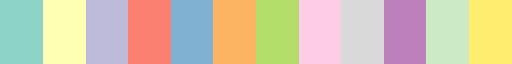

In [24]:
colors = [plt.cm.Set3(i) for i in range(20)]
high_regime=colors[0]
low_regime=colors[3]
default_color=colors[4]
default_color2=low_regime
default_color3=high_regime
default_color4=colors[5]
plt.cm.get_cmap('Set3')

### Data preprocessing

In [25]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])

data=cb_new[['target_name', 'industry', 'id_x', 'date_y', 'size_real', 'target_founded', 'target_status', 'round_simp']]
data.date_y=data.date_y.dt.year
a=data.groupby(['round_simp']).count()
a['target_name']=a.target_name/data.shape[0]
remove=['Asset Sale', 'Bridge', 'Dead', 'Debt', 'Distressed & Special Situation', 'Leveraged Buyout', 'Line of Credit', 
 'Loan', 'Management Buyout', 'Milestone Payment', 'Other Investors', 'Portfolio Merger', 'Portfolio NewCo',
 'Secondary Market', 'Shareholder Liquidity']

data=data[data.size_real>0]
#data=data[~data.target_founded.isna()]
data=data[data.date_y<2021]
data=data.loc[data.industry.isna()==False,]
data=data.loc[~data.round_simp.isin(remove)]

content=data[['industry','id_x', 'target_name', 'target_founded', 'target_status']].drop_duplicates()
content['alive']=np.where(content.target_status.isin(['Alive / Active']),1,0)

data=data.groupby(['id_x','target_name','date_y']).mean().reset_index()
data=data.pivot('date_y','id_x','size_real')

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
content.head()

,industry,id_x,target_name,target_founded,target_status,alive
8838,Biotechnology,6693,Genentech,1976.0,Acquired,0
8865,Pharmaceuticals / Drugs,6708,Vestar Research,NaN,IPO / Went public,0
8867,Medical Devices & Equipment,6710,Diagnostic Technology,NaN,Alive / Active,1
8869,Stealth Mode,6711,Computer Design & Applica,NaN,Dead / Inactive,0
8874,Healthcare Software,6713,Diacon Systems,NaN,Dead / Inactive,0


In [6]:
#content.industry.value_counts()

### Processing

#### Window analysis

In [230]:
percentage=[]
for size in range(5,13):
    data_size=extract_window(size)
    data_size=data_size.loc[:, (data_size != data_size.iloc[0]).any()]
    clusters=functional_clustering(data_size)
    percentage.append(sum(clusters.values())/len(clusters.values()))

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [231]:
win_big=[]
for size in range(5,13):
    data_size=extract_window(size)
    data_size=data_size.loc[:, (data_size != data_size.iloc[0]).any()]
    win_big.append(data_size.shape[1])

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


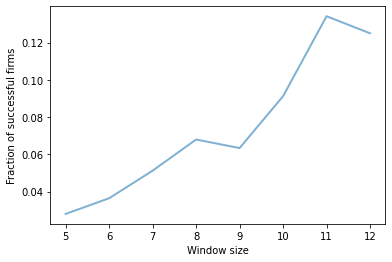

In [232]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(range(5,13), percentage, c=default_color, linewidth=2)
plt.xlabel('Window size')
plt.ylabel('Fraction of successful firms')
#plt.title('Fraction of high-regime firms by window size')

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('fraction_high_regime.pdf', bbox_inches="tight")

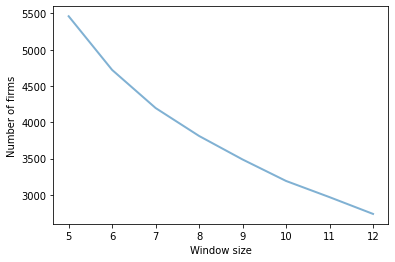

In [233]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(range(5,13), win_big, c=default_color, linewidth=2)
plt.xlabel('Window size')
plt.ylabel('Number of firms')
#plt.title('Number of firms by window size')

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('number_firms_window_size.pdf', bbox_inches="tight")

In [27]:
size=10
data_size=extract_window(size)
# Remove constant columns
data_size=data_size.loc[:, (data_size != data_size.iloc[0]).any()]
#data_size=data_size.apply(np.log)

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [12]:
data_size.head()

,17,23,26,32,36,46,47,50,54,64,...,15718,15720,15722,15726,15729,15732,15736,15746,15755,15756
0,2.172304e+07,7.560706e+06,5.965489e+06,6.805763e+06,1.979740e+05,1.030622e+07,9.519398e+06,5.720251e+06,5.449261e+07,6.673551e+06,...,5.542835e+06,1.879096e+07,5.191126e+07,12427.881999,1.988461e+06,3.159168e+07,273413.403970,1.242788e+06,1.662851e+07,3.728365e+06
1,2.172304e+07,1.947403e+07,1.971183e+07,6.805763e+06,3.916830e+05,1.030622e+07,1.260846e+07,5.720251e+06,1.223816e+08,2.204220e+07,...,5.542835e+06,1.879096e+07,5.191126e+07,12427.881999,1.988461e+06,3.159168e+07,541555.713339,1.242788e+06,1.662851e+07,3.728365e+06
2,6.267970e+07,1.947403e+07,1.971183e+07,1.469913e+07,1.027576e+06,1.156774e+07,1.260846e+07,5.720251e+06,1.223816e+08,2.204220e+07,...,3.593193e+07,1.879096e+07,7.849110e+07,24403.040101,1.988461e+06,4.471860e+07,541555.713339,1.242788e+06,7.593201e+07,1.569621e+08
3,1.019741e+08,1.947403e+07,1.971183e+07,1.469913e+07,1.027576e+06,1.156774e+07,1.559321e+07,3.792720e+07,1.917965e+08,2.204220e+07,...,3.593193e+07,1.879096e+07,7.849110e+07,24403.040101,6.754048e+06,4.471860e+07,541555.713339,1.242788e+06,7.593201e+07,1.569621e+08
4,1.019741e+08,1.947403e+07,5.960066e+07,1.469913e+07,1.027576e+06,1.156774e+07,1.559321e+07,5.196370e+07,1.917965e+08,2.204220e+07,...,7.343772e+07,1.879096e+07,7.849110e+07,24403.040101,7.007860e+06,4.471860e+07,541555.713339,2.982456e+06,7.593201e+07,1.569621e+08


In [8]:
clusters=functional_clustering(data_size)

In [9]:
print('Percentage of successful firms:', 100*sum(clusters.values())/len(clusters.values()), '%')

Percentage of successful firms: 16.89453125 %


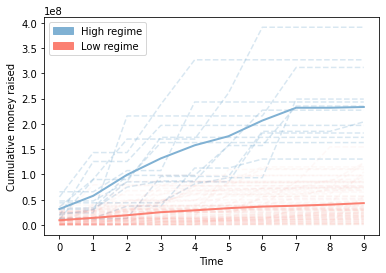

In [10]:
toplot=data_size.loc[:, data_size.columns.isin(content[content.industry=='Drug Discovery'].id_x)]
toplot1=toplot.loc[:, toplot.columns.isin([x for x in clusters.keys() if clusters[x]==1])]
toplot0=toplot.loc[:, toplot.columns.isin([x for x in clusters.keys() if clusters[x]==0])]

fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(toplot1, c=default_color, alpha=0.3, linestyle='--')
plt.plot(toplot0, c=low_regime, alpha=0.05, linestyle='--')
plt.plot(range(0,size), np.mean(toplot1, axis=1), c=default_color, linewidth=2)
plt.plot(range(0,size), np.mean(toplot0, axis=1), c=low_regime, linewidth=2)
high_patch = mpatches.Patch(color=default_color, label='High regime')
low_patch = mpatches.Patch(color=low_regime, label='Low regime')
plt.legend(handles=[high_patch, low_patch])
plt.xlabel('Time')
plt.xticks(range(0,size))
plt.ylabel('Cumulative money raised')
#plt.title('Trajectories in Drug Discovery sector by cluster')

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('drug_discovery_clustering_'+str(size)+'.pdf', bbox_inches="tight")

#### Covariates preparation

In [11]:
os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/ANS_all')
covariates=pd.read_csv('covariates.csv', index_col=0)
#covariates=covariates.drop(['voterank_max', 'voterank_min', 'voterank_median', 'voterank_org'], axis=1)
#covariates=covariates.drop(['voterank_org'], axis=1)

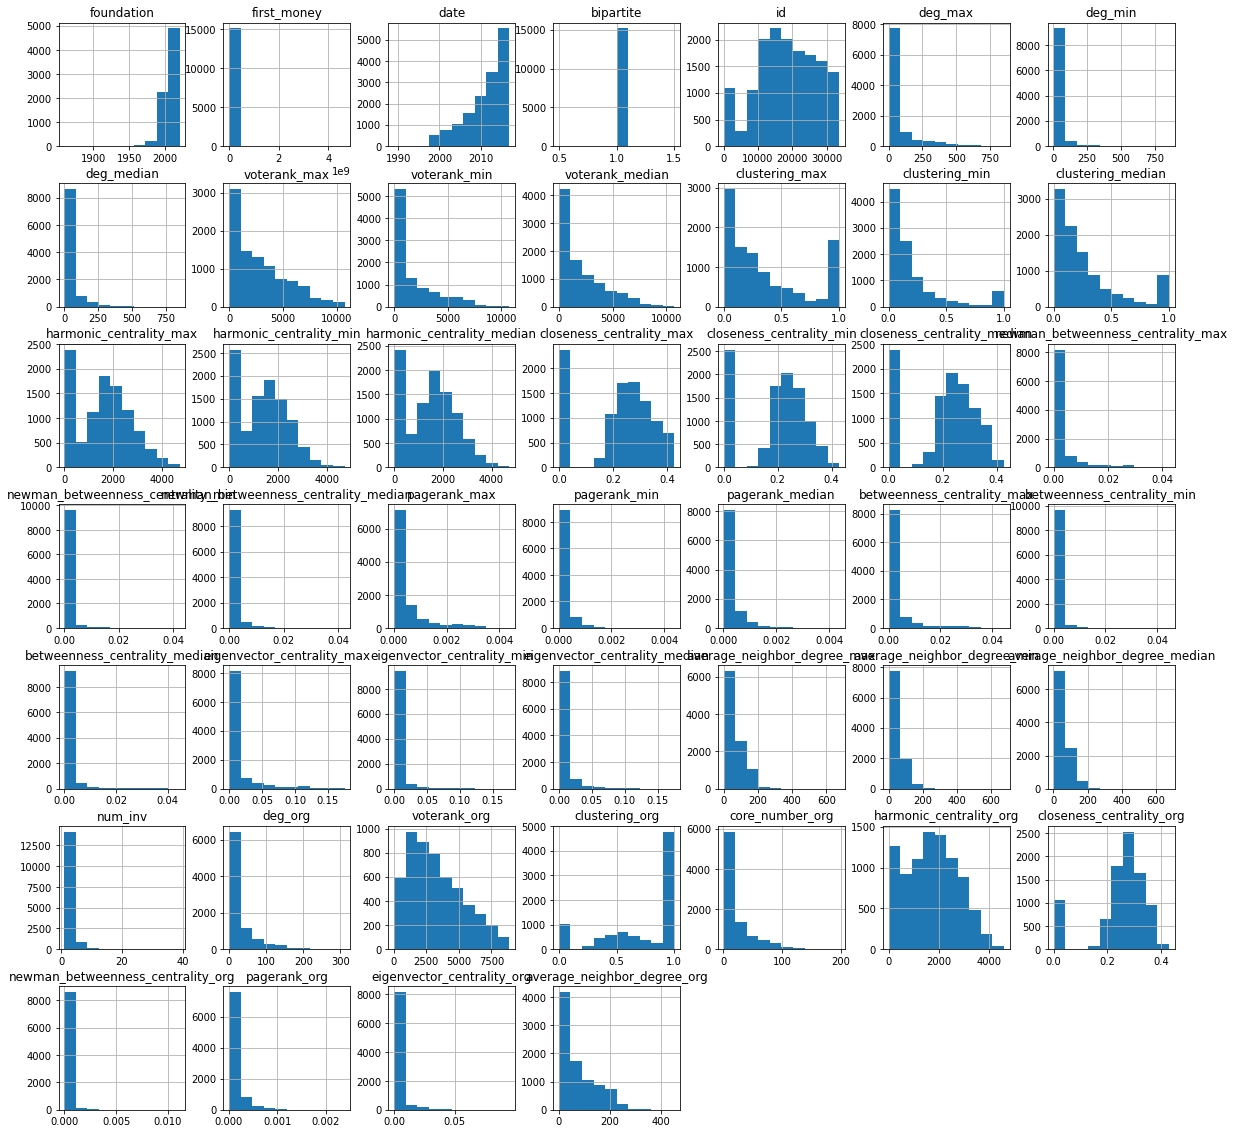

In [248]:
covariates.hist(figsize=(20,20))
os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('covariates_distribution.pdf', bbox_inches="tight")

In [12]:
# Transformations (plotted and chosen individually)
covariates['first_money']=np.log(covariates['first_money'])
covariates['deg_max']=np.log(covariates['deg_max'])
covariates['deg_min']=np.log(covariates['deg_min'])
covariates['deg_median']=np.log(covariates['deg_median'])
covariates['newman_betweenness_centrality_max']=np.log(covariates['newman_betweenness_centrality_max']+0.001)
covariates['newman_betweenness_centrality_min']=np.log(covariates['newman_betweenness_centrality_min']+0.001)
covariates['newman_betweenness_centrality_median']=np.log(covariates['newman_betweenness_centrality_median']+0.001)
covariates['pagerank_max']=np.log(covariates['pagerank_max'])
covariates['pagerank_min']=np.log(covariates['pagerank_min'])
covariates['pagerank_median']=np.log(covariates['pagerank_median'])
covariates['betweenness_centrality_max']=np.log(covariates['betweenness_centrality_max']+0.001)
covariates['betweenness_centrality_min']=np.log(covariates['betweenness_centrality_min']+0.001)
covariates['betweenness_centrality_median']=np.log(covariates['betweenness_centrality_median']+0.001)
covariates['average_neighbor_degree_max']=np.log(covariates['average_neighbor_degree_max'])
covariates['average_neighbor_degree_min']=np.log(covariates['average_neighbor_degree_min'])
covariates['average_neighbor_degree_median']=np.log(covariates['average_neighbor_degree_median'])
covariates['num_inv']=np.log(covariates['num_inv'])
covariates['deg_org']=np.log(covariates['deg_org'])
covariates['core_number_org']=np.log(covariates['core_number_org'])
covariates['newman_betweenness_centrality_org']=np.log(covariates['newman_betweenness_centrality_org']+0.0001)
covariates['pagerank_org']=np.log(covariates['pagerank_org'])

covariates['foundation']=covariates.foundation.apply(str)
covariates['date']=covariates.date.apply(str)

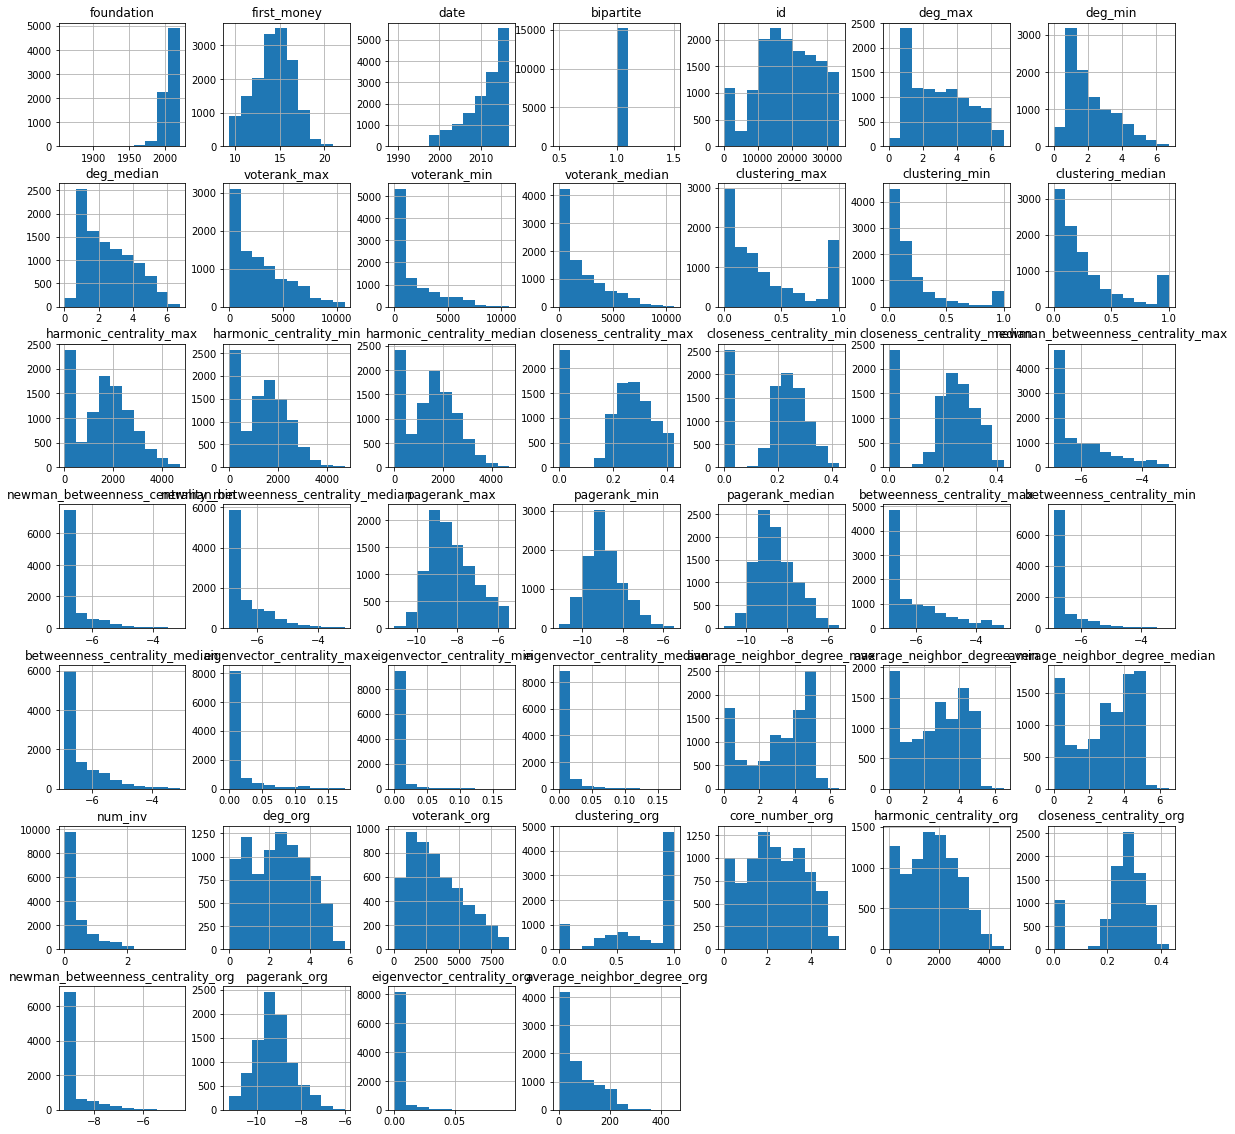

In [51]:
covariates.hist(figsize=(20,20))
os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('covariates_distribution_after_log.pdf', bbox_inches="tight")

In [11]:
Z=covariates.drop(['node','country','continent','industry','foundation','sector', 'stage', 'first_money', 'date', 'current_sit', 'bipartite','id', 'voterank_org'], axis=1)

Z=Z.dropna()

scaler = preprocessing.StandardScaler().fit(Z)
Z_scaled = scaler.transform(Z)
Z_scaled=pd.DataFrame(Z_scaled)
Z_scaled.columns=Z.columns
Z_scaled.shape

(7921, 40)

In [12]:
Z_scaled.corr().reset_index()#.iloc[22,:]

,index,deg_max,deg_min,deg_median,voterank_max,voterank_min,voterank_median,clustering_max,clustering_min,clustering_median,...,num_inv,deg_org,clustering_org,core_number_org,harmonic_centrality_org,closeness_centrality_org,newman_betweenness_centrality_org,pagerank_org,eigenvector_centrality_org,average_neighbor_degree_org
0,deg_max,1.000000,0.613401,0.902862,-0.321806,-0.678131,-0.638273,0.149695,-0.147071,-0.035666,...,0.462350,0.743357,-0.000300,0.725326,0.373630,0.768302,0.355241,0.258136,0.450487,0.761064
1,deg_min,0.613401,1.000000,0.802178,-0.517179,-0.404089,-0.497756,-0.202901,0.094353,-0.083150,...,-0.161789,0.476405,0.213794,0.497922,0.281785,0.501639,-0.064514,0.049922,0.223980,0.537069
2,deg_median,0.902862,0.802178,1.000000,-0.468801,-0.602792,-0.639009,-0.050480,-0.071739,-0.138352,...,0.187565,0.690027,0.091925,0.687911,0.346659,0.711149,0.179182,0.202218,0.404176,0.731070
3,voterank_max,-0.321806,-0.517179,-0.468801,1.000000,0.573201,0.757991,0.252875,-0.003776,0.166436,...,0.185304,-0.257604,-0.179926,-0.276849,0.163059,-0.301216,0.008937,-0.317801,-0.189023,-0.257322
4,voterank_min,-0.678131,-0.404089,-0.602792,0.573201,1.000000,0.933286,-0.158386,0.138335,-0.014207,...,-0.397483,-0.491785,-0.013781,-0.476096,-0.133858,-0.545760,-0.271355,-0.320869,-0.239215,-0.424427
5,voterank_median,-0.638273,-0.497756,-0.639009,0.757991,0.933286,1.000000,-0.044877,0.091966,0.058826,...,-0.260867,-0.489154,-0.043382,-0.478581,-0.052632,-0.521876,-0.225988,-0.379062,-0.266963,-0.424867
6,clustering_max,0.149695,-0.202901,-0.050480,0.252875,-0.158386,-0.044877,1.000000,0.520844,0.819143,...,0.511854,-0.058212,-0.220380,-0.093295,0.054705,0.199850,0.233944,-0.054266,0.031677,0.010758
7,clustering_min,-0.147071,0.094353,-0.071739,-0.003776,0.138335,0.091966,0.520844,1.000000,0.772576,...,-0.182311,-0.282554,-0.008908,-0.274561,-0.032252,-0.014024,-0.164765,-0.231875,-0.136106,-0.120166
8,clustering_median,-0.035666,-0.083150,-0.138352,0.166436,-0.014207,0.058826,0.819143,0.772576,1.000000,...,0.199991,-0.234956,-0.089376,-0.243114,0.011779,0.066871,-0.008216,-0.202583,-0.096741,-0.094142
9,harmonic_centrality_max,0.604259,0.413348,0.550122,0.057463,-0.310994,-0.221651,0.165507,0.014299,0.085908,...,0.219316,0.461129,0.079331,0.456420,0.875266,0.521847,0.092361,-0.379070,-0.028115,0.470702


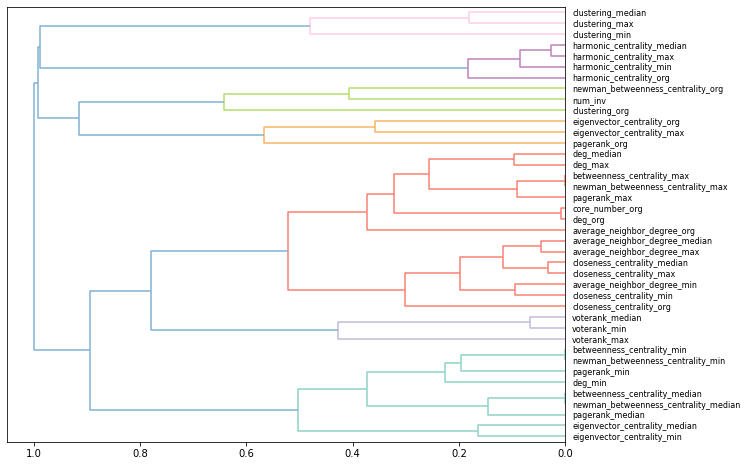

In [13]:
link = linkage(squareform(Z_scaled.corr().apply(lambda x: 1- np.abs(x))), method='complete')
fig = plt.figure(figsize=(10, 8))
set_link_color_palette([pltcol.rgb2hex(colors[0]), pltcol.rgb2hex(colors[2]), pltcol.rgb2hex(colors[3]), pltcol.rgb2hex(colors[5]), pltcol.rgb2hex(colors[6]), pltcol.rgb2hex(colors[9]), pltcol.rgb2hex(colors[7])])
dn=dendrogram(link, labels=Z.columns, leaf_rotation=0, above_threshold_color=pltcol.rgb2hex(default_color), orientation='left')
#plt.title('Feature dendrogram')
os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('dendrogram.pdf', bbox_inches="tight")


Chosen covariates (maximise intra-cluster correlation)
- clustering_median
- harmonic_centrality_max
- num_inv
- eigenvector_centrality_org
- pagerank_max
- voterank_med
- newman_betweenness_centrality_min



#### Logistic regression

In [14]:
clusters=functional_clustering(data_size)

In [15]:
binary=pd.DataFrame(clusters.keys(), clusters.values()).reset_index()
binary.columns=['cluster', 'idx']
binary['idx']=binary.idx.apply(float)

In [16]:
binary_merge=pd.merge(binary, covariates, left_on='idx', right_on='id')
binary_merge.index=binary_merge.idx
binary_merge=binary_merge.drop(['node', 'id', 'bipartite', 'idx'], axis=1)
binary_merge['num_inv']=binary_merge.num_inv.apply(float)
cat=binary_merge.select_dtypes(exclude=['float64'])
num=binary_merge.select_dtypes(include=['float64'])

scaler = preprocessing.StandardScaler().fit(num)
num_scaled = scaler.transform(num)
num_scaled=pd.DataFrame(num_scaled)
num_scaled.columns=num.columns
num_scaled.index=cat.index

binary_merge=pd.concat([cat, num_scaled], axis=1)

In [13]:
formula_log='cluster ~ deg_min + voterank_min + average_neighbor_degree_max + eigenvector_centrality_max + clustering_org + harmonic_centrality_min + clustering_min + first_money'

In [18]:
results = smf.logit(formula_log, data=binary_merge).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.414233
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                cluster   No. Observations:                 1921
Model:                          Logit   Df Residuals:                     1912
Method:                           MLE   Df Model:                            8
Date:                Thu, 27 Jan 2022   Pseudo R-squ.:                  0.2072
Time:                        18:58:53   Log-Likelihood:                -795.74
converged:                       True   LL-Null:                       -1003.7
Covariance Type:            nonrobust   LLR p-value:                 7.040e-85
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.2540      0.110    -20.495      0.000   

In [138]:
pseudor=[]
pvalues=[]
coef=[]
for i in range(1000):
    pos=binary_merge[binary_merge.cluster==1]
    neg=binary_merge[binary_merge.cluster==0].sample(pos.shape[0])
    balanced=pd.concat([pos,neg])
    results = smf.logit(formula_log, data=balanced).fit()
    pseudor.append(results.prsquared)
    pvalues.append(results.pvalues)
    coef.append(results.params)

Optimization terminated successfully.
         Current function value: 0.536358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535016
  

0.22044488677907073

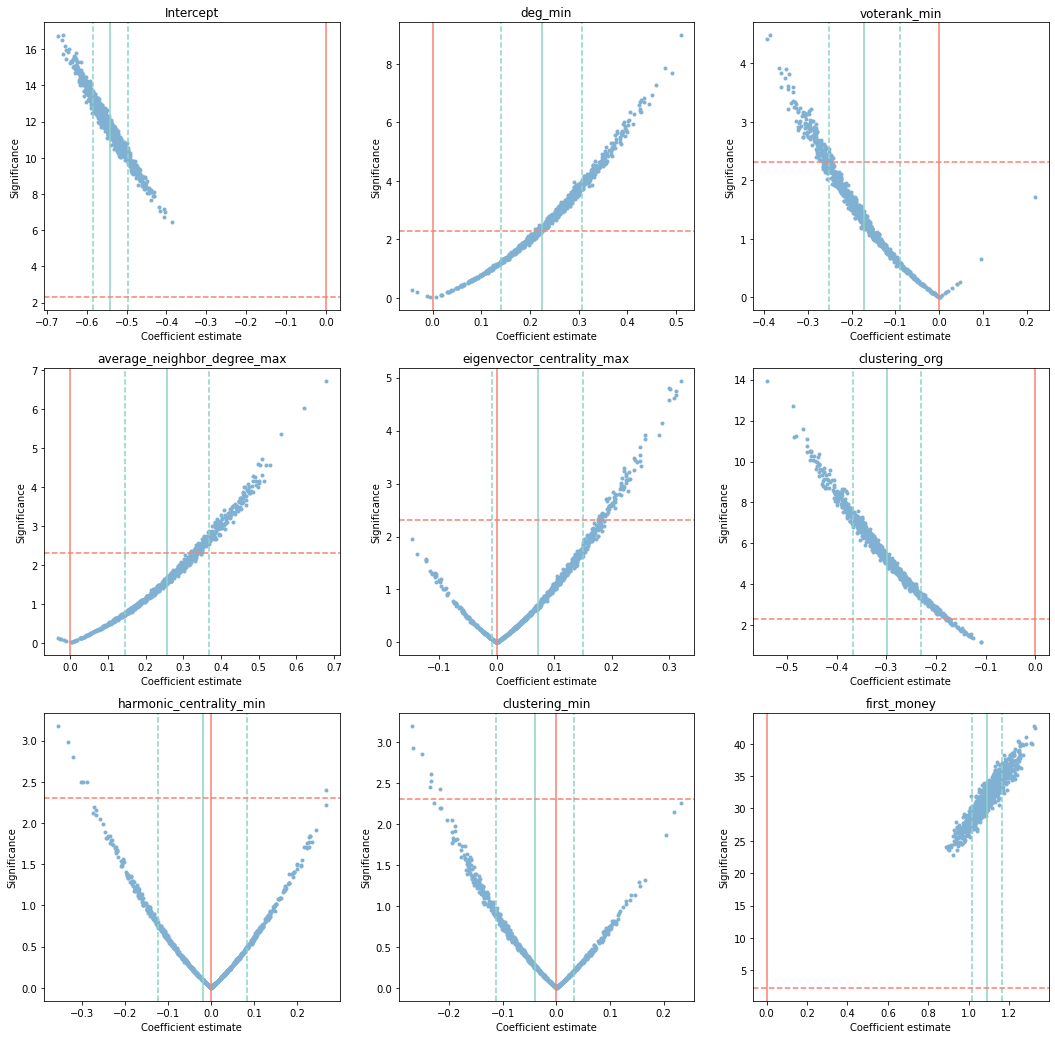

In [140]:
significance=[x.apply(lambda x: -np.log(x)) for x in pvalues]

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

for i in range(9):
    axs[i//3, i%3].plot([x[i] for x in coef], [x[i] for x in significance], '.', c=default_color)
    axs[i//3, i%3].axvline(np.mean([x[i] for x in coef]), c=default_color3)
    axs[i//3, i%3].axvline(np.mean([x[i] for x in coef])-np.std([x[i] for x in coef]), linestyle='--', c=default_color3)
    axs[i//3, i%3].axvline(np.mean([x[i] for x in coef])+np.std([x[i] for x in coef]), linestyle='--', c=default_color3)
    axs[i//3, i%3].set_title(significance[0].index[i])

for ax in axs.flat:
    ax.set(xlabel='Coefficient estimate', ylabel='Significance')
for ax in axs.flat:
    ax.axhline(-np.log(0.1),color=default_color2,ls='--')
    ax.axvline(0, c=default_color2)

#axs[2, 2].set_visible(False)

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('significance_logistic_'+str(size)+'.pdf', bbox_inches="tight")

np.mean(pseudor)

#### Linear regression

In [28]:
cumulate=data_size.loc[data_size.shape[0]-1,:]
cumulate=pd.DataFrame(cumulate).reset_index()
cumulate.columns=['idx', 'cum']
#cumulate['diff']=cumulate['cum']-covariates[covariates.id.isin(cumulate.idx)].reset_index().first_money
cumulate['cum']=cumulate.cum.apply(np.log)
covariates['id']=covariates.id.apply(float)

In [29]:
# Scale only X
cumulative_merge=covariates.copy()
cumulative_merge.index=cumulative_merge.id
cumulative_merge=cumulative_merge.drop(['node', 'id', 'bipartite'], axis=1)

cat=cumulative_merge.select_dtypes(exclude=['float64', 'int64'])
num=cumulative_merge.select_dtypes(include=['float64', 'int64'])

scaler = preprocessing.StandardScaler().fit(num)
num_scaled = scaler.transform(num)
num_scaled=pd.DataFrame(num_scaled)
num_scaled.columns=num.columns
num_scaled.index=cat.index

cumulative_merge=pd.concat([cat, num_scaled], axis=1)
cumulative_merge=pd.merge(cumulate, cumulative_merge, left_on='idx', right_index=True)
cumulative_merge.index=cumulative_merge['idx']

#cumulative_merge['diff_y']=cumulative_merge.cum-cumulative_merge.first_money

In [319]:
# Scale both X and y
cumulative_merge=pd.merge(cumulate, covariates, left_on='idx', right_on='id')
cumulative_merge.index=cumulative_merge.idx
cumulative_merge=cumulative_merge.drop(['node', 'id', 'bipartite', 'idx'], axis=1)

cat=cumulative_merge.select_dtypes(exclude=['float64', 'int64'])
num=cumulative_merge.select_dtypes(include=['float64', 'int64'])

scaler = preprocessing.StandardScaler().fit(num)
num_scaled = scaler.transform(num)
num_scaled=pd.DataFrame(num_scaled)
num_scaled.columns=num.columns
num_scaled.index=cat.index

cumulative_merge=pd.concat([cat, num_scaled], axis=1)
#cumulative_merge['diff_y']=cumulative_merge.cum-cumulative_merge.first_money

In [30]:
formula='cum ~ deg_min + voterank_min + average_neighbor_degree_max + eigenvector_centrality_max + clustering_org + harmonic_centrality_min + clustering_min + sector + continent + first_money'

In [31]:
results = smf.ols(formula, data=cumulative_merge).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cum   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     113.4
Date:                Fri, 04 Feb 2022   Prob (F-statistic):          1.47e-262
Time:                        17:38:02   Log-Likelihood:                -2844.1
No. Observations:                1921   AIC:                             5722.
Df Residuals:                    1904   BIC:                             5817.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

#### Best subset selection

In [100]:
def processSubset(feature_set, X, y):
    model = sm.OLS(y, X.loc[:, list(feature_set)], missing='drop')
    regr = model.fit()
    rsquared=regr.rsquared_adj
    return {"model":regr, "R2":rsquared}

def getBest(k, X, y):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo, X, y))
    models = pd.DataFrame(results)
    best_model = models.loc[models['R2'].argmax()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds")
    return best_model

In [101]:
# Could take quite a while to complete...
models_best = pd.DataFrame(columns=["R2", "model"])
tic = time.time()
for i in range(1,3):
    models_best.loc[i] = getBest(i, cumulative_merge.drop(['country','continent','industry','foundation','sector', 'stage', 'first_money', 'date', 'current_sit', 'voterank_org', 'cum'], axis=1), cumulative_merge.cum)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds")

Processed 40 models on 1 predictors in 0.20589303970336914 seconds
Processed 780 models on 2 predictors in 4.17799711227417 seconds
Total elapsed time: 4.422933101654053 seconds


In [102]:
models_best.model.iloc[1].params

closeness_centrality_max    0.57611
clustering_org             -0.21009
dtype: float64

In [105]:
def forward(predictors, X, y):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X, y))
    models = pd.DataFrame(results)
    best_model = models.loc[models['R2'].argmax()]
    toc = time.time()
    #print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds")
    # Return the best model, along with some other useful information about the model
    return best_model

models_fwd = pd.DataFrame(columns=["R2", "model"])
tic = time.time()
predictors = []
for i in range(1,len(cumulative_merge.drop(['country','continent','industry','foundation','sector', 'stage', 'first_money', 'date', 'current_sit', 'voterank_org', 'cum'], axis=1).columns)+1):    
    models_fwd.loc[i] = forward(predictors, cumulative_merge.drop(['country','continent','industry','foundation','sector', 'stage', 'first_money', 'date', 'current_sit', 'voterank_org', 'cum'], axis=1), cumulative_merge.cum)
    predictors = models_fwd.loc[i]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds")

Total elapsed time: 18.389711141586304 seconds


In [107]:
models_fwd.model.iloc[10].params

deg_max                           0.332879
clustering_org                   -0.095891
average_neighbor_degree_max       0.118354
num_inv                           0.190535
core_number_org                  -0.168865
harmonic_centrality_max          -0.153475
voterank_min                      0.036331
clustering_max                   -0.077549
average_neighbor_degree_median    0.157051
average_neighbor_degree_org       0.086557
closeness_centrality_median       0.092629
dtype: float64

In [113]:
a=cumulative_merge.drop(['country','continent','industry','foundation','sector', 'stage', 'first_money', 'date', 'current_sit', 'voterank_org', 'cum'], axis=1).dropna(axis = 0)
regr = ElasticNetCV(cv=5, random_state=0, l1_ratio=[x/100 for x in range(1,105,5)], verbose=False)
regr.fit(a, cumulative_merge[cumulative_merge.index.isin(a.index)].cum)

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40989302659181703, tolerance: 0.28844457497568415
 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5706601764097741, tolerance: 0.28844457497568415
 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3181776208707561, tolerance: 0.2912736836996762
 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning:Objective did not

ElasticNetCV(cv=5,
             l1_ratio=[0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41,
                       0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86,
                       0.91, 0.96, 1.01],
             random_state=0, verbose=False)

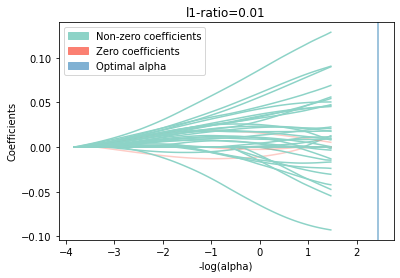

In [114]:
eps = 5e-3
alphas_enet, coefs_enet, _ = enet_path(a, cumulative_merge[cumulative_merge.index.isin(a.index)].cum, eps=eps, l1_ratio=regr.l1_ratio_)
neg_log_alphas_enet = -np.log(alphas_enet)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
for i in range(len(coefs_enet)):
    coef_e=coefs_enet[i]
    if regr.coef_[i]!=0:
        plt.plot(neg_log_alphas_enet, coef_e, c=default_color3)
    else:
        plt.plot(neg_log_alphas_enet, coef_e, c=default_color2, alpha=0.4)
plt.xlabel("-log(alpha)")
plt.ylabel("Coefficients")
ax.axvline(-np.log(regr.alpha_), c=default_color)
plt.title("l1-ratio="+str(regr.l1_ratio_))
patcha = mpatches.Patch(color=default_color3, label='Non-zero coefficients')
patchb = mpatches.Patch(color=default_color2, label='Zero coefficients')
patchc = mpatches.Patch(color=default_color, label='Optimal alpha')
plt.legend(handles=[patcha, patchb, patchc])

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('elastic_net_coefficients_'+str(size)+'.pdf', bbox_inches="tight")

In [211]:
a.loc[:,regr.coef_!=0].columns

Index(['deg_max', 'clustering_min', 'eigenvector_centrality_max',
       'average_neighbor_degree_max', 'average_neighbor_degree_median',
       'num_inv', 'clustering_org', 'closeness_centrality_org'],
      dtype='object')

In [212]:
regr.coef_

array([ 0.23774739,  0.        ,  0.        , -0.        , -0.00779133,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.00210697,  0.        ,  0.        ,  0.04630281,
        0.        ,  0.16941763,  0.05531134,  0.        , -0.13948957,
        0.        ,  0.        ,  0.03356903,  0.        , -0.        ,
        0.        ,  0.        ])

#### Function-on-scalar regression

Function-on-scalar regression is not supported in Python. We have to work in R. Some tricks and we are still in the Python environment. Many thanks to rpy2!

In [18]:
#os.chdir('/Library/Frameworks/R.framework/Versions/4.0/Resources')
#os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.0/Resources'

base = importr('base')
refund = importr('refund')
dplyr = importr('dplyr')
tibble = importr('tibble')
stats = importr('stats')

In [252]:
with localconverter(ro.default_converter + pandas2ri.converter):
  covariates_R=ro.conversion.py2rpy(cumulative_merge.drop(['cum', 'country', 'continent', 'industry', 'foundation', 'sector', 'stage', 'date', 'current_sit'], axis=1))

with localconverter(ro.default_converter + pandas2ri.converter):
  response_R=ro.conversion.py2rpy(data_size)

with localconverter(ro.default_converter + pandas2ri.converter):
  log_response_R=ro.conversion.py2rpy(data_size.apply(np.log))


In [253]:
covariates_R = base.as_matrix(base.cbind(1, covariates_R.rx(True, -1)))
response_R = base.t(base.as_matrix(response_R))
log_response_R = base.t(base.as_matrix(log_response_R))

rows=base.c(1, 4, 7, 30, 27, 36, 13, 10, 2) # These SHOULD be correct -- Please Lorenzo do not forget to check!

olsmod = refund.fosr(Y=response_R.rx(stats.complete_cases(covariates_R.rx(True, rows)), True), X=covariates_R.rx(stats.complete_cases(covariates_R.rx(True,rows)),rows), method='OLS', l=0.000001)
log_olsmod = refund.fosr(Y=log_response_R.rx(stats.complete_cases(covariates_R.rx(True, rows)), True), X=covariates_R.rx(stats.complete_cases(covariates_R.rx(True,rows)),rows), method='OLS', l=0.000001)

In [254]:
coef_estimate=base.as_data_frame(olsmod[5])
se_estimate=base.as_data_frame(olsmod[6])

with localconverter(ro.default_converter + pandas2ri.converter):
  fun_coef = ro.conversion.rpy2py(coef_estimate)

with localconverter(ro.default_converter + pandas2ri.converter):
  fun_se = ro.conversion.rpy2py(se_estimate)

coef_estimate=base.as_data_frame(log_olsmod[5])
se_estimate=base.as_data_frame(log_olsmod[6])

with localconverter(ro.default_converter + pandas2ri.converter):
  log_fun_coef = ro.conversion.rpy2py(coef_estimate)

with localconverter(ro.default_converter + pandas2ri.converter):
  log_fun_se = ro.conversion.rpy2py(se_estimate)

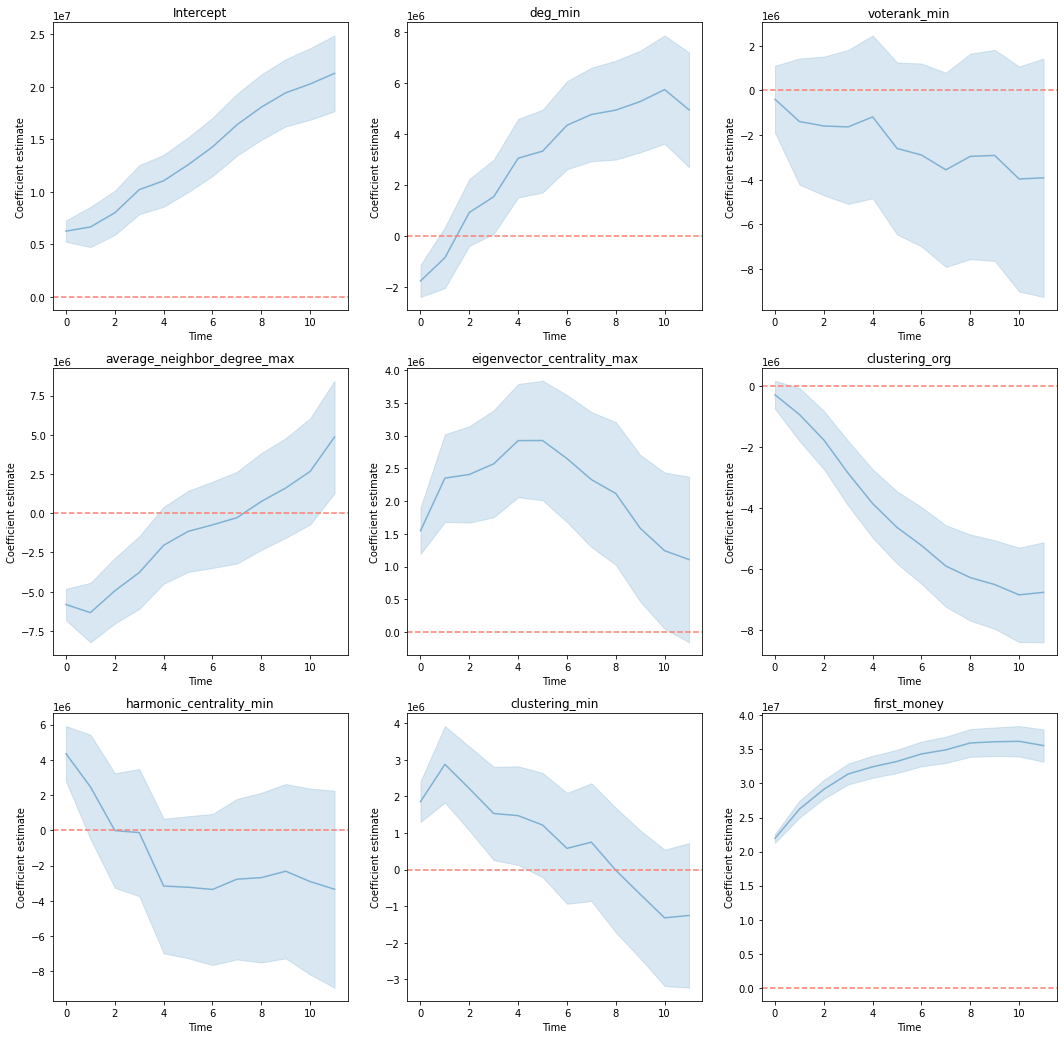

In [255]:
names=['Intercept', 'deg_min', 'voterank_min', 'average_neighbor_degree_max', 'eigenvector_centrality_max', 'clustering_org', 'harmonic_centrality_min', 'clustering_min', 'first_money']

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

for i in range(9):
    axs[i//3, i%3].plot(range(0,fun_coef.shape[0]), fun_coef.iloc[:,i], '-', c=default_color)
    axs[i//3, i%3].fill_between(range(0,fun_coef.shape[0]), fun_coef.iloc[:,i] - fun_se.iloc[:,i], fun_coef.iloc[:,i] + fun_se.iloc[:,i], color=default_color, alpha=0.3)
    axs[i//3, i%3].set_title(names[i])

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Coefficient estimate')
    ax.axhline(0,color=default_color2,ls='--')

#axs[2, 1].set_visible(False)
#axs[2, 2].set_visible(False)

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('functional_coefficients_'+str(size)+'.pdf', bbox_inches="tight")

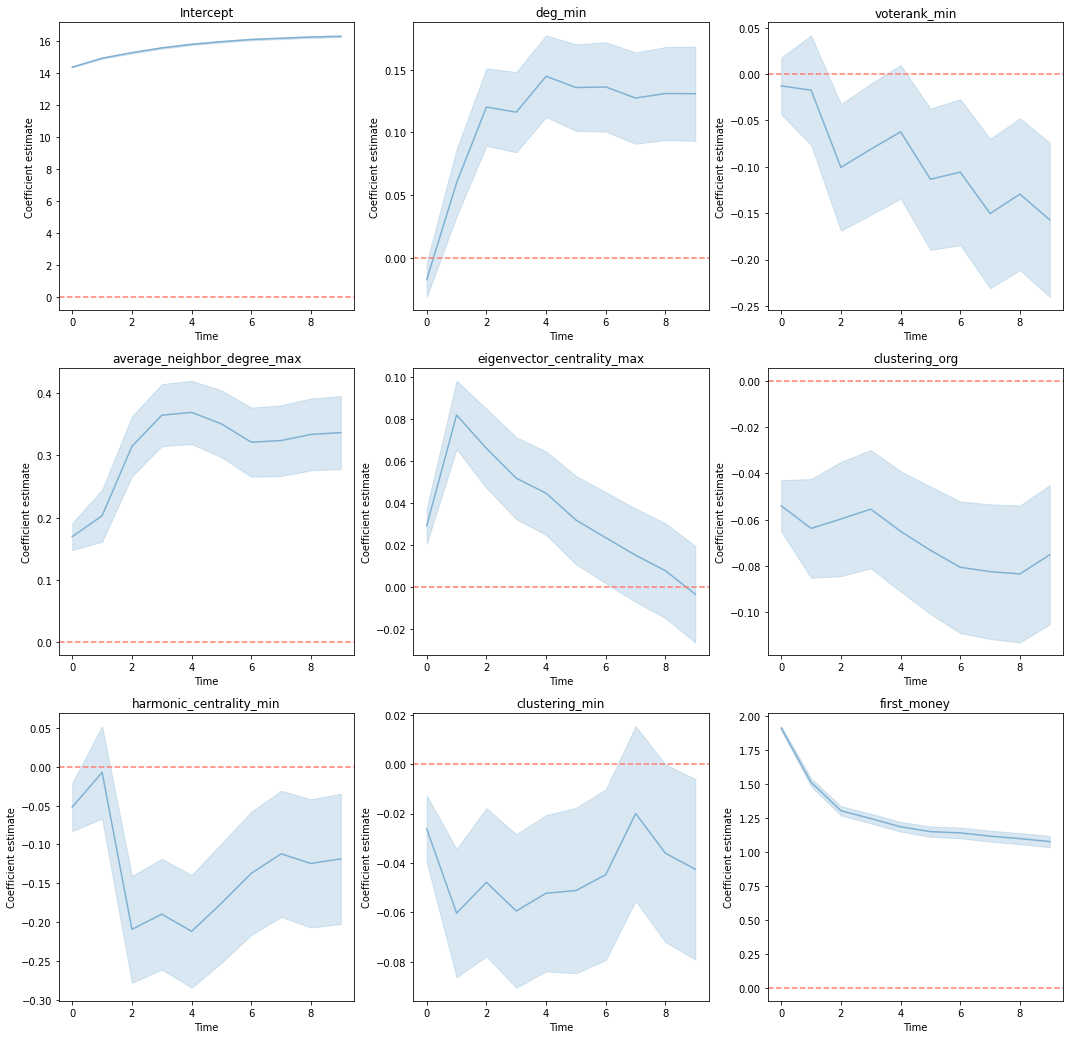

In [162]:
names=['Intercept', 'deg_min', 'voterank_min', 'average_neighbor_degree_max', 'eigenvector_centrality_max', 'clustering_org', 'harmonic_centrality_min', 'clustering_min', 'first_money']

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

for i in range(9):
    axs[i//3, i%3].plot(range(0,log_fun_coef.shape[0]), log_fun_coef.iloc[:,i], '-', c=default_color)
    axs[i//3, i%3].fill_between(range(0,log_fun_coef.shape[0]), log_fun_coef.iloc[:,i] - log_fun_se.iloc[:,i], log_fun_coef.iloc[:,i] + log_fun_se.iloc[:,i], color=default_color, alpha=0.3)
    axs[i//3, i%3].set_title(names[i])

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Coefficient estimate')
    ax.axhline(0,color=default_color2,ls='--')

#axs[2, 1].set_visible(False)
#axs[2, 2].set_visible(False)

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('log_functional_coefficients_'+str(size)+'.pdf', bbox_inches="tight")

#### Stability analysis

##### Logistic

In [19]:
prsquared=[]
l_bound=[]
u_bound=[]
coef=[]
for size in range(5,13):
    data_size=extract_window(size)
    data_size=data_size.loc[:, (data_size != data_size.iloc[0]).any()]
    clusters=functional_clustering(data_size)
    binary=pd.DataFrame(clusters.keys(), clusters.values()).reset_index()
    binary.columns=['cluster', 'idx']
    binary['idx']=binary.idx.apply(float)
    binary_merge=pd.merge(binary, covariates, left_on='idx', right_on='id')
    binary_merge.index=binary_merge.idx
    binary_merge=binary_merge.drop(['node', 'id', 'bipartite', 'idx'], axis=1)
    binary_merge['num_inv']=binary_merge.num_inv.apply(float)
    cat=binary_merge.select_dtypes(exclude=['float64'])
    num=binary_merge.select_dtypes(include=['float64'])
    scaler = preprocessing.StandardScaler().fit(num)
    num_scaled = scaler.transform(num)
    num_scaled=pd.DataFrame(num_scaled)
    num_scaled.columns=num.columns
    num_scaled.index=cat.index
    binary_merge=pd.concat([cat, num_scaled], axis=1)
    results = smf.logit(formula_log, data=binary_merge).fit()
    prsquared.append(results.prsquared)
    coef.append(results.params)
    l_bound.append(results.conf_int().iloc[:,0])
    u_bound.append(results.conf_int().iloc[:,1])
coef=pd.DataFrame(coef).reset_index()
u_bound=pd.DataFrame(u_bound).reset_index()
l_bound=pd.DataFrame(l_bound).reset_index()

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Optimization terminated successfully.
         Current function value: 0.262087
         Iterations 8


 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Optimization terminated successfully.
         Current function value: 0.267253
         Iterations 8


 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Optimization terminated successfully.
         Current function value: 0.199981
         Iterations 9


 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Optimization terminated successfully.
         Current function value: 0.383724
         Iterations 7


 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Optimization terminated successfully.
         Current function value: 0.363097
         Iterations 7


 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Optimization terminated successfully.
         Current function value: 0.414233
         Iterations 7


 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Optimization terminated successfully.
         Current function value: 0.378899
         Iterations 8


 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Optimization terminated successfully.
         Current function value: 0.387742
         Iterations 8


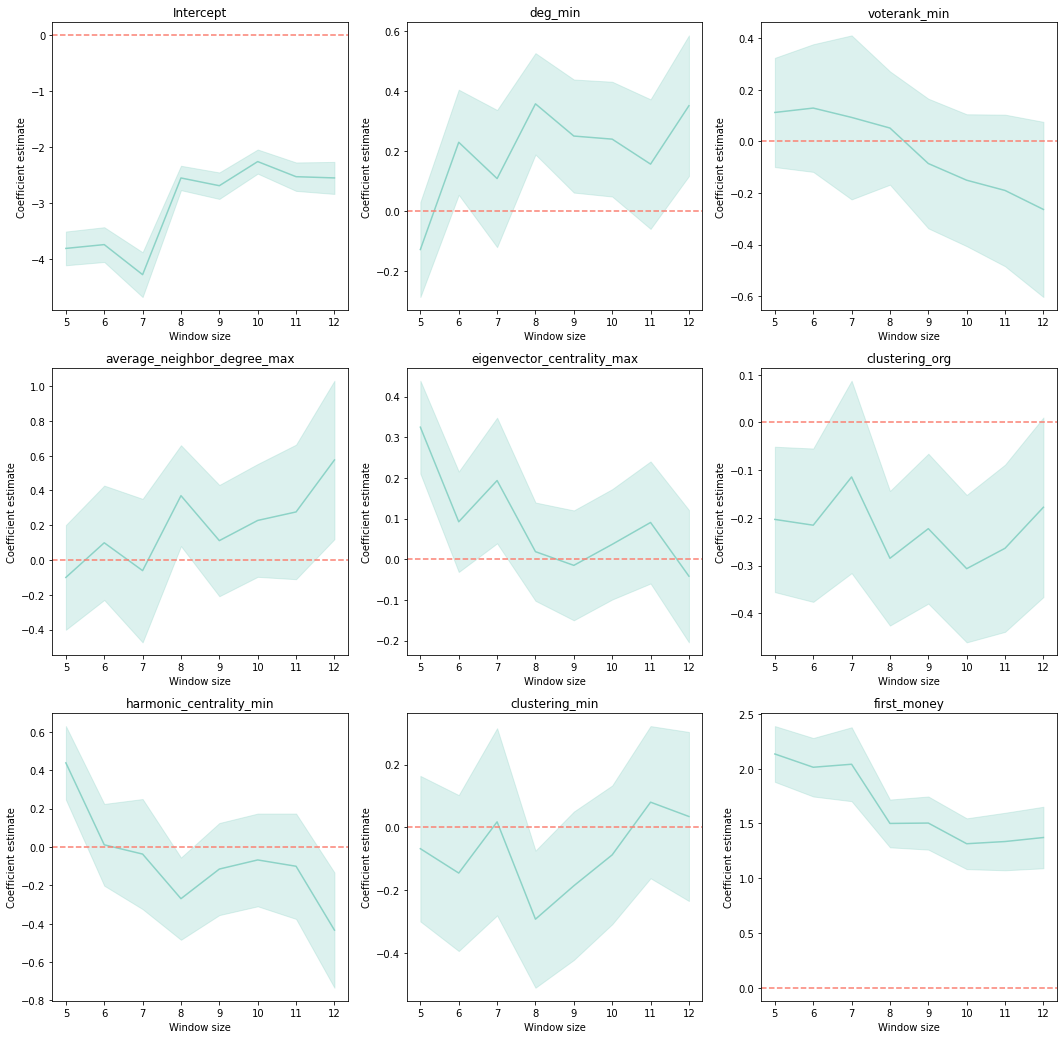

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

for i in range(9):
    axs[i//3, i%3].plot(range(5,13), coef.iloc[:,i+1], color=default_color3)
    axs[i//3, i%3].fill_between(range(5,13), l_bound.iloc[:,i+1], u_bound.iloc[:,i+1], alpha=0.3, color=default_color3)
    axs[i//3, i%3].set_title(coef.columns[i+1])

for ax in axs.flat:
    ax.set(xlabel='Window size', ylabel='Coefficient estimate')
    ax.axhline(0,color=default_color2,ls='--')

#axs[2, 1].set_visible(False)
#axs[2, 2].set_visible(False)

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('stability_logistic.pdf', bbox_inches="tight")

##### Linear

In [32]:
rsquared=[]
l_bound=[]
u_bound=[]
coef=[]
for size in range(5,13):
    data_size=extract_window(size)
    data_size=data_size.loc[:, (data_size != data_size.iloc[0]).any()]
    cumulate=data_size.loc[data_size.shape[0]-1,:]
    cumulate=pd.DataFrame(cumulate).reset_index()
    cumulate.columns=['idx', 'cum']
    cumulate['cum']=cumulate.cum.apply(np.log)
    covariates['id']=covariates.id.apply(float)
    cumulative_merge=covariates.copy()
    cumulative_merge.index=cumulative_merge.id
    cumulative_merge=cumulative_merge.drop(['node', 'id', 'bipartite'], axis=1)
    cat=cumulative_merge.select_dtypes(exclude=['float64', 'int64'])
    num=cumulative_merge.select_dtypes(include=['float64', 'int64'])
    scaler = preprocessing.StandardScaler().fit(num)
    num_scaled = scaler.transform(num)
    num_scaled=pd.DataFrame(num_scaled)
    num_scaled.columns=num.columns
    num_scaled.index=cat.index
    cumulative_merge=pd.concat([cat, num_scaled], axis=1)
    cumulative_merge=pd.merge(cumulate, cumulative_merge, left_on='idx', right_index=True)
    cumulative_merge.index=cumulative_merge['idx']
    results = smf.ols(formula, data=cumulative_merge).fit()
    rsquared.append(results.rsquared_adj)
    coef.append(results.params)
    l_bound.append(results.conf_int().iloc[:,0])
    u_bound.append(results.conf_int().iloc[:,1])

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [33]:
rows=[0,1,11,12,13,14,15,16,17,18]
coef=pd.DataFrame(coef).reset_index().iloc[:, rows]
u_bound=pd.DataFrame(u_bound).reset_index().iloc[:, rows]
l_bound=pd.DataFrame(l_bound).reset_index().iloc[:, rows]

In [65]:
l_bound.iloc[:,i+1]#-coef.iloc[:,i+1]

0   -0.052703
1   -0.058847
2   -0.063755
3   -0.069080
4   -0.075828
5   -0.083097
6   -0.087746
7   -0.091878
Name: first_money, dtype: float64

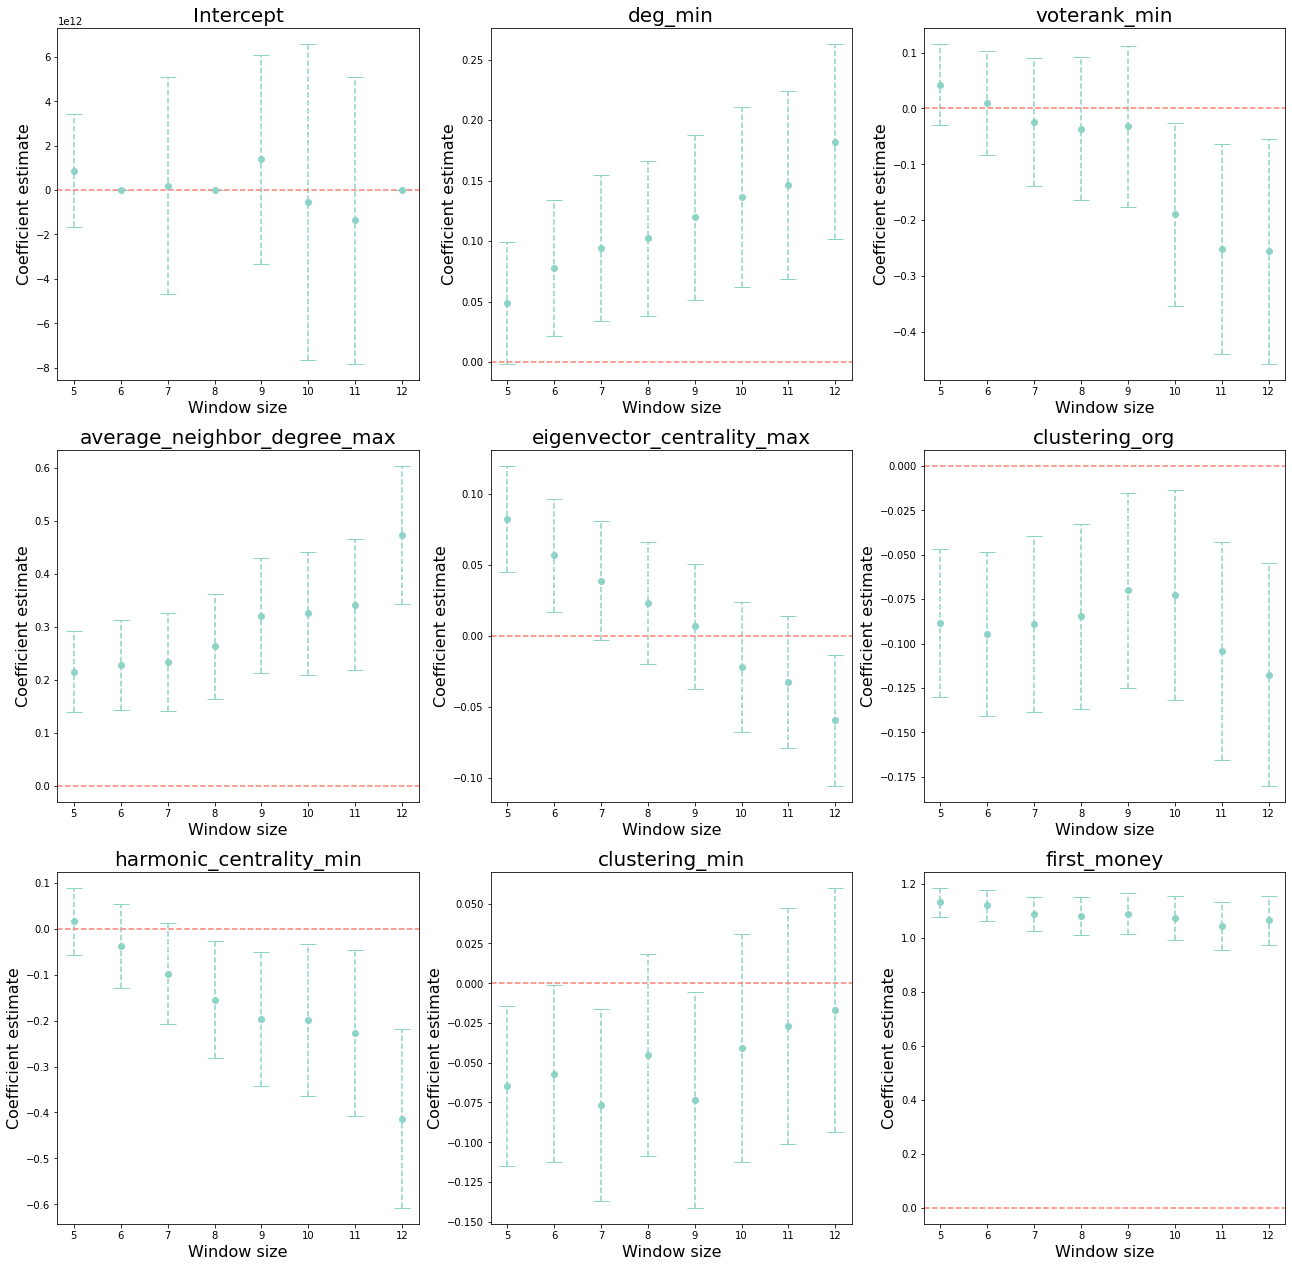

In [80]:
fig, axs = plt.subplots(3, 3, figsize=(22, 22))

for i in range(9):
    #axs[i//3, i%3].plot(range(5,13), coef.iloc[:,i+1], color=default_color3)
    #axs[i//3, i%3].errorbar(range(5,13), coef.iloc[:,i+1], yerr=)
    y_error=[-l_bound.iloc[:,i+1]+coef.iloc[:,i+1], u_bound.iloc[:,i+1]-coef.iloc[:,i+1]]
    eb=axs[i//3, i%3].errorbar(range(5,13), coef.iloc[:,i+1], yerr = y_error,fmt='o', ecolor = default_color3 , color= default_color3, capsize=8)
    eb[-1][0].set_linestyle('--')

    #axs[i//3, i%3].fill_between(range(5,13), l_bound.iloc[:,i+1], u_bound.iloc[:,i+1], alpha=0.3, color=default_color3)
    axs[i//3, i%3].set_title(coef.columns[i+1], fontsize=20)

for ax in axs.flat:
    ax.set_xlabel('Window size', fontsize=16)
    ax.set_ylabel('Coefficient estimate', fontsize=16)
    ax.axhline(0,color=default_color2,ls='--')

#axs[2, 1].set_visible(False)
#axs[2, 2].set_visible(False)

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('stability_linear.pdf', bbox_inches="tight")

##### Functional

In [20]:
lst_coef=[]
lst_se=[]
lst_coef_log=[]
lst_se_log=[]

for size in range(5,13):
    data_size=extract_window(size)
    data_size=data_size.loc[:, (data_size != data_size.iloc[0]).any()]
    cumulate=data_size.loc[data_size.shape[0]-1,:]
    cumulate=pd.DataFrame(cumulate).reset_index()
    cumulate.columns=['idx', 'cum']
    cumulate['cum']=cumulate.cum.apply(np.log)
    covariates['id']=covariates.id.apply(float)
    cumulative_merge=covariates.copy()
    cumulative_merge.index=cumulative_merge.id
    cumulative_merge=cumulative_merge.drop(['node', 'id', 'bipartite'], axis=1)
    cat=cumulative_merge.select_dtypes(exclude=['float64', 'int64'])
    num=cumulative_merge.select_dtypes(include=['float64', 'int64'])
    scaler = preprocessing.StandardScaler().fit(num)
    num_scaled = scaler.transform(num)
    num_scaled=pd.DataFrame(num_scaled)
    num_scaled.columns=num.columns
    num_scaled.index=cat.index
    cumulative_merge=pd.concat([cat, num_scaled], axis=1)
    cumulative_merge=pd.merge(cumulate, cumulative_merge, left_on='idx', right_index=True)
    cumulative_merge.index=cumulative_merge['idx']

    with localconverter(ro.default_converter + pandas2ri.converter):
        covariates_R=ro.conversion.py2rpy(cumulative_merge.drop(['cum', 'country', 'continent', 'industry', 'foundation', 'sector', 'stage', 'date', 'current_sit', 'idx'], axis=1))
    with localconverter(ro.default_converter + pandas2ri.converter):
        response_R=ro.conversion.py2rpy(data_size)
    with localconverter(ro.default_converter + pandas2ri.converter):
        log_response_R=ro.conversion.py2rpy(data_size.apply(np.log))
    covariates_R = base.as_matrix(base.cbind(1, covariates_R))
    response_R = base.t(base.as_matrix(response_R))
    log_response_R = base.t(base.as_matrix(log_response_R))
    rows=base.c(1, 4, 7, 30, 27, 36, 13, 10, 2) # These SHOULD be correct -- Please Lorenzo do not forget to check!
    olsmod = refund.fosr(Y=response_R.rx(stats.complete_cases(covariates_R.rx(True, rows)), True), X=covariates_R.rx(stats.complete_cases(covariates_R.rx(True,rows)),rows), method='OLS', l=0.000001)
    log_olsmod = refund.fosr(Y=log_response_R.rx(stats.complete_cases(covariates_R.rx(True, rows)), True), X=covariates_R.rx(stats.complete_cases(covariates_R.rx(True,rows)),rows), method='OLS', l=0.000001)
    
    coef_estimate=base.as_data_frame(olsmod[5])
    se_estimate=base.as_data_frame(olsmod[6])
    with localconverter(ro.default_converter + pandas2ri.converter):
        fun_coef = ro.conversion.rpy2py(coef_estimate)
    with localconverter(ro.default_converter + pandas2ri.converter):
        fun_se = ro.conversion.rpy2py(se_estimate)
    lst_coef.append(fun_coef)
    lst_se.append(fun_se)

    coef_estimate=base.as_data_frame(log_olsmod[5])
    se_estimate=base.as_data_frame(log_olsmod[6])
    with localconverter(ro.default_converter + pandas2ri.converter):
        log_fun_coef = ro.conversion.rpy2py(coef_estimate)
    with localconverter(ro.default_converter + pandas2ri.converter):
        log_fun_se = ro.conversion.rpy2py(se_estimate)
    lst_coef_log.append(log_fun_coef)
    lst_se_log.append(log_fun_se)   

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

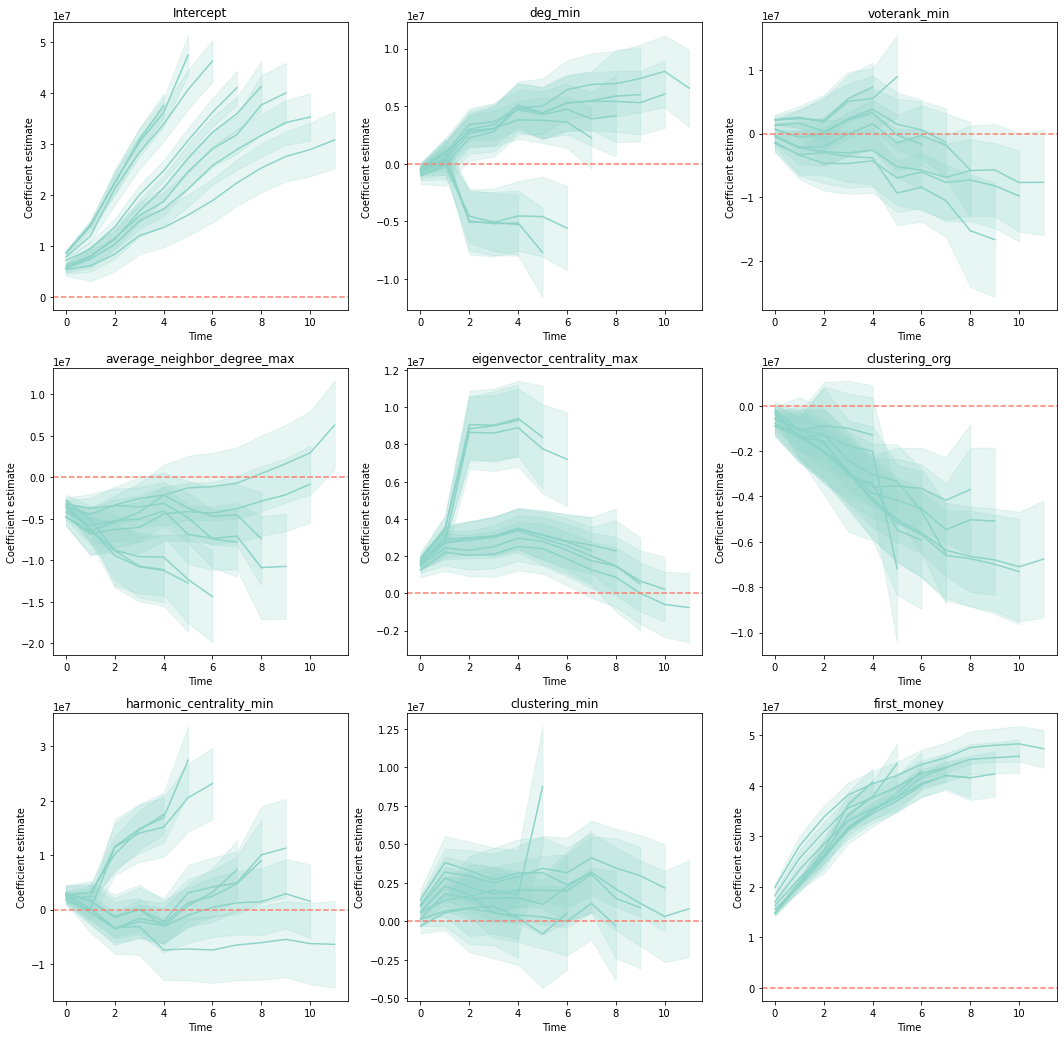

In [21]:
names=['Intercept', 'deg_min', 'voterank_min', 'average_neighbor_degree_max', 'eigenvector_centrality_max', 'clustering_org', 'harmonic_centrality_min', 'clustering_min', 'first_money']

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

for model in range(len(lst_coef)):
    for i in range(len(names)):
        axs[i//3, i%3].plot(range(lst_coef[model].shape[0]), lst_coef[model].iloc[:,i], '-', c=default_color3)
        axs[i//3, i%3].fill_between(range(lst_se[model].shape[0]), lst_coef[model].iloc[:,i] - lst_se[model].iloc[:,i], lst_coef[model].iloc[:,i] + lst_se[model].iloc[:,i], color=default_color3, alpha=0.2)
        axs[i//3, i%3].set_title(names[i])

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Coefficient estimate')
    ax.axhline(0,color=default_color2,ls='--')

#axs[2, 1].set_visible(False)
#axs[2, 2].set_visible(False)

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('stability_functional.pdf', bbox_inches="tight")